<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/DataWranglingEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Language Classsifier
Identify the gender and/or native language of speakers reading a fixed passage in English.

The goal is to use the pre-trained vggish model to extract features from audio files, and train a classifier to identify the gender and/or native language or the speaker.

The data is a subset of the Speech Accent Archive, available from https://www.kaggle.com/rtatman/speech-accent-archive

In [355]:
# Set up the environment
!pip install pyAudioAnalysis
!pip install hmmlearn
!pip install eyed3
!pip install pydub
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display

from pyAudioAnalysis import audioSegmentation as aS

import os
import random

import tensorflow as tf
import tensorflow_hub as hub

# Data wrangling
## Load the data and metadata

In [356]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [357]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
data  kaggle.json  reading-passage.txt	recordings  speakers_all.csv


In [358]:
# Copy Kaggle API command - only needs to be done the first time
#!kaggle datasets download -d rtatman/speech-accent-archive

In [359]:
# unzip the zip files and remove the zip files - only needs to be done the first time
#!unzip \*.zip && rm *.zip

In [360]:
text = pd.read_csv('reading-passage.txt', header=None, delimiter='.')
text.head().T

,0
0,Please call Stella
1,Ask her to bring these things with her from ...
2,We also need a small plastic snake and a big...
3,She can scoop these things into three red ba...
4,NaN


In [361]:
meta = pd.read_csv('speakers_all.csv')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [362]:
# Drop 3 end columns with NaN values
meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


# EDA
- How many speakers per native language?
- What are the top languages present in the database?
- What is the distribution of speakers by gender and language?
- How many dialects of English are represented? (native_language == English, by birthplace and country values)


In [363]:
# How many unique values are there per column?
meta.nunique()

age                  80
age_onset            59
birthplace         1290
filename           2156
native_language     214
sex                   3
country             176
file_missing?         2
dtype: int64

In [364]:
# How many columns have null values?
meta.isnull().sum()

age                0
age_onset          0
birthplace         4
filename           0
native_language    0
sex                0
country            5
file_missing?      0
dtype: int64

In [365]:
meta[meta.birthplace.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


In [366]:
meta[meta.country.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


It makes sense that the synthesized audio files would not have birthplace or country information, since a synthesized voice would not have a birthplace or country.
Since I want to train the model on real voices, I will delete the synthesized voices from the data.

In [367]:
meta.dropna(subset=['birthplace'], inplace=True)
meta[meta.native_language=='lao']

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
248,19.0,12.0,"savannakhet, laos",lao1,lao,female,laos,False
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
2007,52.0,20.0,"pakxe, laos",lao3,lao,male,laos,False


The remaining missing value is in the country column from one Lao speaker. Since the other two Lao speakers have Laos as their country, I will impute Laos as the country value for the remaining speaker as well.

In [368]:
meta.loc[meta.country.isnull(), 'country'] = 'laos'
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

In [369]:
meta.shape

(2168, 8)

### Missing files
What are the missing files? If there are missing audio files, they will not be available for feature extraction, so they should be removed from the dataframe before the audio files are processed.

In [370]:
meta['file_missing?'].value_counts()

False    2136
True       32
Name: file_missing?, dtype: int64

In [371]:
missingIdx = meta[meta['file_missing?']==True].index
meta.loc[missingIdx].head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
318,28.0,11.0,"colombo, sri lanka",sinhalese2,sinhalese,female,sri lanka,True
380,38.0,4.0,"madang, madang province, papua new guinea",tok,tok,male,papua new guinea,True
425,25.0,5.0,"jammu, kashmir, india",poonchi1,poonchi,male,india,True
461,25.0,8.0,"colombo, sri lanka",sinhalese3,sinhalese,female,sri lanka,True
493,21.0,10.0,"eischoll, switzerland",swiss,swiss,male,switzerland,True


In [372]:
# Remove records with missing files - The files don't have unique names, and are not available in the recordings folder.
meta.drop(missingIdx, inplace=True )
meta.shape

(2136, 8)

In [373]:
# filenames 'nicaragua', 'sinhalese1' are not present
nica_index = meta[meta.filename == 'nicaragua'].index
sinhalese_index = meta[meta.filename=='sinhalese1'].index
meta.drop(nica_index, inplace=True, axis=0)
meta.drop(sinhalese_index, inplace=True, axis=0)
meta.shape

(2134, 8)

### How many speakers per native language?

In [374]:
# How many native languages, total?
meta.native_language.nunique()

199

In [375]:
# Hard to see the scope because there are so many with only one speaker
meta.native_language.value_counts()

english     579
spanish     162
arabic      102
mandarin     65
french       63
           ... 
susu          1
gan           1
hindko        1
akan          1
malagasy      1
Name: native_language, Length: 199, dtype: int64

In [376]:
# How many native languages with only one speaker in the database?
meta.native_language.value_counts().loc[meta.native_language.value_counts() == 1]

carolinian    1
hakka         1
dinka         1
nuer          1
naxi          1
             ..
susu          1
gan           1
hindko        1
akan          1
malagasy      1
Name: native_language, Length: 78, dtype: int64

There are 80 native languages represented by only one speaker in the database. This means there are 121 languages represented by 2 or more speakers.

### What are the top 10 languages in the data, in addition to English?

In [377]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [378]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

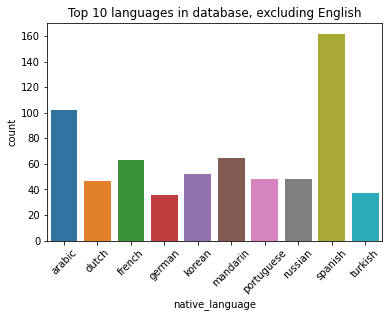

In [379]:
sns.countplot(x='native_language', data=top_lang)
plt.title('Top 10 languages in database, excluding English')
plt.xticks(rotation=45)

### What is the distribution of speakers by gender?

In [380]:
# There is one record with 'famale', which is assumed to be a typo.
type_idx = meta[meta.sex =='famale'].index
meta.loc[type_idx, 'sex'] = 'female'
meta.sex.value_counts()

male      1100
female    1034
Name: sex, dtype: int64

Text(0.5, 1.0, 'Distibution of speakers by gender - All')

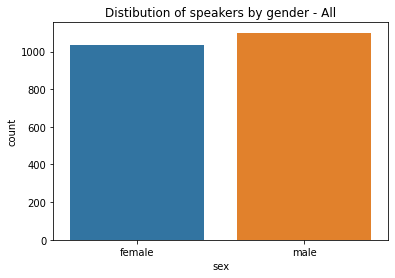

In [381]:
sns.countplot(x='sex', data=meta)
plt.title('Distibution of speakers by gender - All')

Text(0.5, 1.0, 'Distribution of speakers by gender - Top 10')

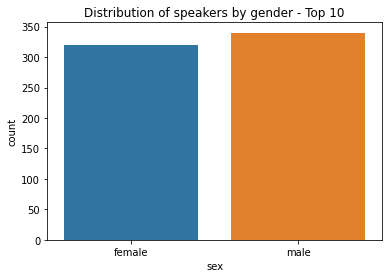

In [382]:
sns.countplot(x='sex', data=top_lang)
plt.title('Distribution of speakers by gender - Top 10')

### How many varieties of (native) Engish are represented in the database?
While we don't know which varieity of English the native speakers use, we can infer the variety by looking at their birthplace and country.

In [383]:
# How many varieties of English are represented in the database?
english = meta.loc[meta.native_language == 'english']
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
malaysia                  2
philippines               2
guyana                    2
ghana                     1
us virgin islands         1
fiji                      1
papua new guinea          1
antigua and barbuda       1
germany                   1
spain                     1
trinidad                  1
bolivia                   1
isle of man               1
the bahamas               1
switzerland               1
belize                    1
lebanon                   1
italy                     1
barbados                  1
virginia                  1
nigeria                   1
united arab emirates      1
liberia                   1
pakistan                  1
Name: country, dtype

In [384]:
english.country.nunique()

35

Text(0.5, 1.0, 'Native English speakers by country')

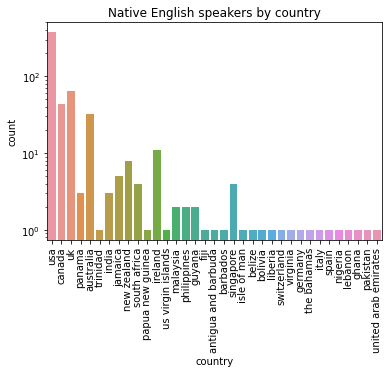

In [385]:
sns.countplot(x='country', data=english)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Native English speakers by country')

In [386]:
english.birthplace.value_counts()

sydney, australia                        8
washington, district of columbia, usa    7
toronto, ontario, canada                 7
dublin, ireland                          6
chicago, illinois, usa                   6
                                        ..
mishawaka, indiana, usa                  1
baltic, south dakota, usa                1
blytheville, arkansas, usa               1
st. thomas, us virgin islands            1
kansas city, kansas, usa                 1
Name: birthplace, Length: 421, dtype: int64

In [387]:
english.birthplace.str.contains('usa').sum()

373

In [388]:
english.birthplace.str.contains('uk').sum()

67

In [389]:
english.birthplace.str.contains('canada').sum()

44

In [390]:
english.birthplace.str.contains('australia').sum()

32

The birthplace column is a bit hard to parse for country, since the column entries include cities, optional provinces/states, and country. However, the number of speakers from each country by birthplace seem to correspond to a high degree, when the birthplace column is filtered for the top 4 "countries".

# Audio Files
## Segmentation
Since the speakers read a fixed English passage with 4 sentences, I expect that the resulting audio files are going to be fairly long.

First, we will load a random file to see how long it is, and to examine how it can be segmented into smaller segments at pauses.

In [391]:
# Load a sample audio file - play the audio file and look at the waveform
# Choose a random sound file to examine
filename = random.choice(meta.filename)
filepath = 'recordings/recordings/' + filename + '.mp3'
print(filepath)

recordings/recordings/ibibio1.mp3


In [392]:
ipd.Audio(filepath)

In [393]:
# Set sample rate to 16k, to fit with Vggish model
SAMP_RATE = 16000
y, sr = librosa.load(filepath, sr=SAMP_RATE)

Text(0.5, 1.0, 'Waveform of audio file')

<Figure size 1080x216 with 0 Axes>

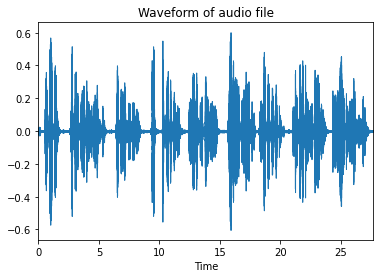

In [394]:
plt.figure(figsize=(15, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Waveform of audio file')

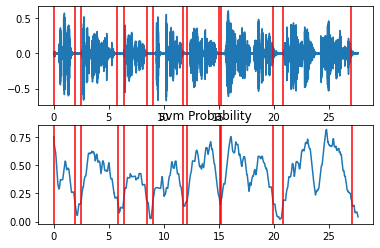

In [395]:
# https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation

# segments is a list of endpoints
segments = aS.silence_removal(y, SAMP_RATE, 0.020, 0.020, smooth_window = 1.0, weight = 0.15, plot = True)

In [396]:
print(segments)

[[0.0, 1.92], [2.5, 5.8], [6.36, 8.44], [9.02, 11.72], [12.120000000000001, 15.06], [15.200000000000001, 19.900000000000002], [20.86, 27.060000000000002]]


In [397]:
# Segment the audio files at the pauses and return the segments in a dictionary
def get_segments(audio, samp_rate):
  segments = aS.silence_removal(audio, samp_rate, 0.020, 0.020, smooth_window = 1.0, weight = 0.15, plot = False)
  seg_files = {}
  for idx, seg in enumerate(segments):
    beg = int(seg[0] * samp_rate)
    ending = int(seg[1] * samp_rate)
    new_audio = audio[beg:ending]
    seg_files[idx] = new_audio
  return seg_files

### Comments on segmentation
Running the segmentation algorithm on a variety of different files elsewhere gives different results for different audio files. Some segments are really short, while others are longer. Most files are segmented into at least 4 segments, with some having 8-10 segments, many of which are very short.

While the original idea was to try to segment the files into approximately 4 segments, which correspond roughly to the 4 phrases in the text passage, these segments end up being (much) shorter than the files on which the VGGish model was trained.

At this point, my plan is to segment the files into 10s segments, which correspond to the length of the training files for VGGish. For most of the files in this data set, this will result in at least 2 segments, with up to 5 segments. Segmenting the files into fixed length segments can be done by index slicing on the original file, and don't involve outside functions.

In [398]:
def segment_10s(audio, sr):
  """ Load an audio file and divide into 10 second segments.
  Arguments: audio - the audio file; sr = sampling rate of the file
  Returns: a dictionary of the audio segments. Key is the index of segment, value is the segment.
  """
  seg_files ={}
  n_seg = int((len(audio)/sr)/10)
  for i in range(n_seg):
    segment = audio[10*i*sr:(i+1)*10*sr]
    seg_files[i] = segment
  return seg_files

In [399]:
# Test segment_10s fuction on the sample audio file
y_seg = segment_10s(y, SAMP_RATE)
print(y_seg.keys())

dict_keys([0, 1])


In [400]:
ipd.Audio(y_seg[0], rate=SAMP_RATE)

In [401]:
ipd.Audio(y_seg[1], rate=SAMP_RATE)

In [402]:
# Cycle through segmented files and write each one to a new file; append segment number to filename
#!pip install soundfile
#import soundfile as sf
#def get_segment_files(segment_list, SAMP_RATE):
#  for key, val in segment_list.items():
#    new_name = filename + "." + str(key)
#    filepath = 'recordings/recordings/' + new_name + '.wav'
#    sf.write(filepath, val, samplerate=SAMP_RATE)

## Augment with noise
One way to make the model more robust is to add random noise to the audio files, which double the number of training files, and forces the model to focus on the relevant features while ignoring the noise.

In [403]:
def add_noise(audio):
    '''
    Add random noise to an audio file.
    Arguments: audio - the audio file
    Returns: the noisy audio file
    ''' 
    # Load random number generator
    rng = np.random.default_rng()
    # Generate random noise
    noise = rng.standard_normal(len(audio))
    # Choose weight of noise to add to file
    weights = [0.005, 0.01, 0.015]
    weight = random.choice(weights)
    # Add noise to file
    noisy_seg = audio + weight*noise

    return noisy_seg

In [404]:
# Test the add_noise function on the sample soundfile
y_noise = add_noise(y)
ipd.Audio(y_noise, rate=SAMP_RATE)

## Extract mel spectrogram
The input to the VGGish model is a 96 x 64 mel spectrogram.

In [405]:
# Mel spectrogram parameters
N_MEL_BANDS = 64
FREQ_MIN = 125
FREQ_MAX = 7500
HOP = 1667
WIN = 400
FFT = 512

In [406]:
def extract_mel_spec(audio, sr):
  mel = librosa.feature.melspectrogram(audio, sr, n_mels=N_MEL_BANDS, 
                                     fmin=FREQ_MIN, fmax=FREQ_MAX,
                                     hop_length=HOP, 
                                    n_fft=FFT) #win_length=WIN,
  return mel

(96, 64)
<class 'numpy.ndarray'>


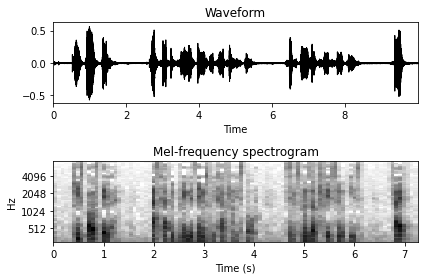

In [429]:
# Try extract_mel_spec and plot
mel_spec = extract_mel_spec(y_seg[0], SAMP_RATE)
print(mel_spec.T.shape)
print(type(mel_spec.T))

fig, axn = plt.subplots(2, 1)
librosa.display.waveplot(y_seg[0], sr=SAMP_RATE, ax=axn[0], color='k')
axn[0].set(title='Waveform')
 
mel_db = librosa.power_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(mel_db, x_axis='s', y_axis='mel', 
                               ax=axn[1], fmin=FREQ_MIN, fmax=FREQ_MAX,
                               cmap='gray_r', hop_length=HOP)#,
                               # n_fft=512) #win_length=win_size,
#fig.colorbar(img, ax=axn[1], format='%+2.0f dB')
axn[1].set(title="Mel-frequency spectrogram")
plt.tight_layout()

# Split data and load
While I want to add noise to the training data, I don't necessarily want to add noise to the testing data.

The first step here is to split the speakers into training and testing lists. The files in the training list will first be segmented, then augmented with noise, and finally the mel spectrogram will be extracted from the original and noisy files.
The files in the testing list will be segmented and have the mel spectrogram extracted.

Metadata about the files will be stored in a pandas dataframe and .csv file, which will track the filename, the segment number, whether the segment is the original or noisy version, and the gender of the speaker.

The mel spectrograms will be saved as a numpy array as the features. The labels will be saves a numpy array. Once the features and labels have been generated and saved as a numpy array, they can be loaded from the text file, instead of needing to be regenerated from the audio files.

## Procedure
- Filter meta_df to select desired files
-- gender classifier - all files
-- language classifier - top 10 files, with downsampled english files
- load training audio files
- segment in 10s chunks
- extract mel spectrogram of original segment
- add noise to segment
- extract mel spectrogram of noisy segement

In [408]:
# Split data into training and testing sets for gender analysis
from sklearn.model_selection import train_test_split
data = meta[['sex', 'filename']]
gender_x_train_temp, gender_x_test, gender_y_train_temp, gender_y_test = train_test_split(data, 
                                                                                data['sex'], 
                                                                                test_size=0.25, 
                                                                                random_state=38, 
                                                                                stratify=data['sex'])
print(gender_x_train_temp.shape)

(1600, 2)


In [430]:
gender_x_train_temp.head()
train_small = gender_x_train_temp.iloc[0:5, :]
train_small.shape

(5, 2)

# Notes to start tomorrow
The load data function seems to work - it loads teh files and extracts the mel spec with the right dimensions.
I'm having trouble formatting the final array
The final array shape should be (7414, 96, 64).

I can get the shape of x to be (7417, ), and the shape of the first element of that array is (96, 64), but I don't know how to get each mel_spec into its own "row".

Reminder to self = erase the text files in Kaggle/data/train so that the function will run.

In [410]:
def load_data(df, train=True):
  """First time through, load audio files, segment them, add noise, extract mel spectrograms, 
  and save extracted spectrograms as numpy arrays. Save labels and metadata
  After the first time, load the text files, since it is faster. """
  # set a train/test variable
  if train == True:
    split = "train"
  else: split = "test"

 # if results are already in a text file or numpy array, load from there
  if os.path.isfile("data/{}/gender_features.npy".format(split)) and os.path.isfile("data/{}/gender_labels.npy".format(split)):
    gender_X = np.load("data/{}/gender_features.npy".format(split))
    gender_y = np.load("data/{}/gender_labels.npy".format(split))
    gender_meta = pd.read_csv("data/{}/gender_train_meta.csv".format(split))
    return gender_X, gender_y, gender_meta

  # If text files don't exist, cycle through the data and extract feature and labels
  gender_meta = pd.DataFrame(columns=['sex', 'filename', 'segment_idx', 'is_noise'])
  gender_X = []
  gender_y = []

  for i in range(df.shape[0]):  #each filename(row) in DF
    #load audio
    sex_string = df.iloc[i, 0]
    if sex_string == 'female':
      sex_int = 0
    else: sex_int = 1

    filename = df.iloc[i, 1]
    filepath = 'recordings/recordings/' + filename + '.mp3'
    y, sr = librosa.load(filepath, sr=SAMP_RATE)

    # Segment audio file
    seg_files = segment_10s(y, SAMP_RATE)

    # For each segment
    for key, val in seg_files.items():
      # Add segment index to gender metadata [sex, filename, segment_idx, noise]
      gender_meta = gender_meta.append({'sex':sex_int, 
                                                  'filename':filename,
                                                  'segment_idx':key,
                                                  'is_noise':0}, ignore_index=True)
      # Extract mel spectrogram
      mel_spec = extract_mel_spec(val, SAMP_RATE)
    
      # Add sex label and mel spec to gender_train list/matrix
      gender_X.append(mel_spec.T)
      gender_y.append(sex_int)

      if train==True:
        # Add noise to segment
        val_noise = add_noise(val)

        # Add noisy segment index to gender metadata [sex, filename, segment_idx, noise]
        gender_meta = gender_meta.append({'sex':sex_int, 
                                                  'filename':filename,
                                                  'segment_idx':key,
                                                  'is_noise':1}, ignore_index=True)

        # Extract noisy mel spectrogram
        mel_spec_noise = extract_mel_spec(val_noise, SAMP_RATE)  # is a np.array
    
        # Add sex label and mel spec to gender_train matrix
        gender_X.append(mel_spec_noise.T)
        gender_y.append(sex_int)
    
  gender_X = np.asarray(gender_X)
  gender_y = np.asarray(gender_y)

  #Save arrays to text files
  np.save("data/{}/gender_features.npy".format(split), gender_X)
  np.save("data/{}/gender_labels.npy".format(split), gender_y)
  gender_meta.to_csv("data/{}/gender_train_meta.csv".format(split))

  return gender_X, gender_y, gender_meta

In [432]:
samp_x, samp_y, samp_meta = load_data(train_small, train=True)

In [433]:
print("X has shape", samp_x.shape)
print("y has shape", samp_y.shape)

X has shape (20,)
y has shape (20,)


In [434]:
print(samp_x)

[array([[8.13983354e-10, 8.07848052e-10, 1.51259009e-09, ...,
        2.42524032e-09, 1.67538445e-09, 1.73167397e-09],
       [7.00817686e-03, 6.96296945e-04, 1.57617610e-04, ...,
        9.37969564e-07, 1.06826399e-06, 1.47346091e-06],
       [1.10197153e-03, 1.69563109e-03, 1.03596915e-03, ...,
        7.73718885e-07, 1.93819234e-06, 1.66559117e-06],
       ...,
       [1.02043087e-03, 3.66255236e-04, 3.79843566e-04, ...,
        7.30873236e-05, 3.52276130e-05, 1.80947655e-05],
       [5.23063855e-04, 1.32824820e-03, 7.26239061e-04, ...,
        1.66923610e-06, 8.19764397e-07, 1.55030262e-06],
       [3.60896818e-01, 1.98398489e+00, 1.01832882e+00, ...,
        3.93354367e-06, 4.06276394e-06, 2.14426238e-06]])
 list([array([[7.81663313e-04, 4.76197192e-03, 4.16648504e-04, ...,
        1.04481431e-03, 1.77900022e-03, 3.57862980e-01],
       [1.65677743e-04, 1.71875230e-03, 1.82997915e-03, ...,
        6.46178720e-04, 1.82017852e-03, 1.96860826e+00],
       [5.77728428e-05, 9.80790254e

In [411]:
gender_X_train, gender_y_train, gender_train_meta = load_data(gender_x_train_temp, train=True)
print("X has shape", gender_X_train.shape)
print("y has shape", gender_y_train.shape)

X has shape (7414,)
y has shape (7414,)


In [412]:
gender_x_train_temp.shape

(1600, 2)

In [ ]:
gender_X_test, gender_y_test, gender_test_meta = load_data(gender_x_test, train=False)
print("X_test has shape", gender_X_test)
print("y_test has shape", gender_y_test)

In [413]:
# Nested dictionary to hold mel spectrograms for every segment of every file
#features_dict = {}
#noise_dict={}
#segment_dict={}

#for audio in df.filename:
#for i in range(x_train_temp.shape[0]):  #each row in DF
  #load audio
#  filename = x_train_temp.iloc[i, 3]
#  filepath = 'recordings/recordings/' + filename + '.mp3'
#  y, sr = librosa.load(filepath, sr=SAMP_RATE)
  # Add original filename as key in dict, add dict as value
#  features_dict[filename] = {'original':{}, 'noise':{}}
#  noise_dict[filename]={}

  # Segment audio
#  seg_dict = get_segments(y, SAMP_RATE)
#  segment_dict[filename] = seg_dict

  # Get mel spec from each segment
#  for key, val in seg_dict.items():
    # Extract mel spec from segment
#    mel_spec = librosa.feature.melspectrogram(val, SAMP_RATE)

    # Add mel_spec to features_dict
#    features_dict[filename]['original'][key] = mel_spec

    # Add noise to segment and extract mel_spec of noisy signal
#    rng = np.random.default_rng()
#    noise = rng.standard_normal(len(val))
#    noisy_seg = val + 0.015*noise
#    noise_dict[filename][key] = noisy_seg

#    noise_mel_spec = librosa.feature.melspectrogram(noisy_seg, SAMP_RATE)
#    features_dict[filename]['noise'][key] = noise_mel_spec

## VGGish notes
VGGish input is : 96x64 for log mel spectrogram audio inputs

From VGGish documentation
VGGish was trained with audio features computed as follows:

- All audio is resampled to 16 kHz mono.
- A spectrogram is computed using magnitudes of the Short-Time Fourier Transform with a window size of 25 ms, a window hop of 10 ms, and a periodic Hann window.
- A mel spectrogram is computed by mapping the spectrogram to 64 mel bins covering the range 125-7500 Hz.
- A stabilized log mel spectrogram is computed by applying log(mel-spectrum + 0.01) where the offset is used to avoid taking a logarithm of zero.
- These features are then framed into non-overlapping examples of 0.96 seconds, where each example covers 64 mel bands and 96 frames of 10 ms each.

VGGish has code for converting audio to input - I could use that, or write my own.


# Gender classifier
- binary options: logistic regression, sigmoid function?

In [414]:
# Load the vggish model from the TF hub
model = hub.load('https://tfhub.dev/google/vggish/1')

# Build a model
- Feature extraction from vggish
- Gender classifier layers

# Train the model

# Evaluate the results

# References
Data from: 
https://www.kaggle.com/rtatman/speech-accent-archive/notebooks

Inspiration and examples from:
https://www.kaggle.com/ejlok1/part-2-extracting-audio-features

Load data function modifed from:
https://www.thepythoncode.com/article/gender-recognition-by-voice-using-tensorflow-in-python